In [1]:
## Import modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")


In [28]:
## Load dataset.
## It's already splitted and cleaned as
'''
pre_covid = merged.loc[merged['ev_year'] < 2020]
post_covid = merged.loc[merged['ev_year'] >= 2020]
pre_covid = pre_covid.reset_index().drop(columns=['index'])

strat_kfold = StratifiedGroupKFold(n_splits = 5, shuffle=True, random_state=412)  # Validation and test will both be 20% of data, hence 5 splits
splits = strat_kfold.split(pre_covid, pre_covid['damage'], pre_covid['ev_id'].astype(str))   # Grouped by 'ev_id', stratified by 'damage'

# data_test <-- test set from the first fold (20% of data)
# data_test <-- test set from the second fold (20% of data)
# data_train <- remaining data (60%)

for i, (train_index, test_index) in enumerate(splits):
    if i==0:
        data_test = pre_covid.iloc[test_index]
        data_train = pre_covid.iloc[train_index]
    elif i==1:
        data_val = pre_covid.iloc[test_index]
        data_train.drop(test_index)
        break

'''

## Randomly sampled, stratified along with the 'damage'
## Train : Val : Test = 6:2:2 (Precovid)


df_train = pd.read_csv('../data/ntsb/cleaned/ntsb_train_cleaned.csv')
df_val = pd.read_csv('../data/ntsb/cleaned/master_val.csv')
df_test = pd.read_csv('../data/ntsb/cleaned/master_test.csv')
df_post_covid = pd.read_csv('../data/ntsb/cleaned/master_post_covid.csv')


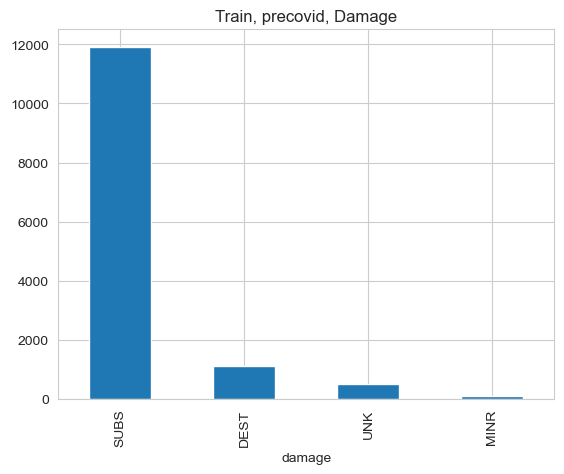

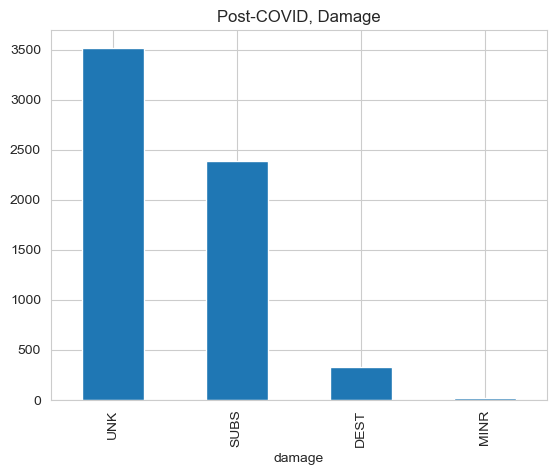

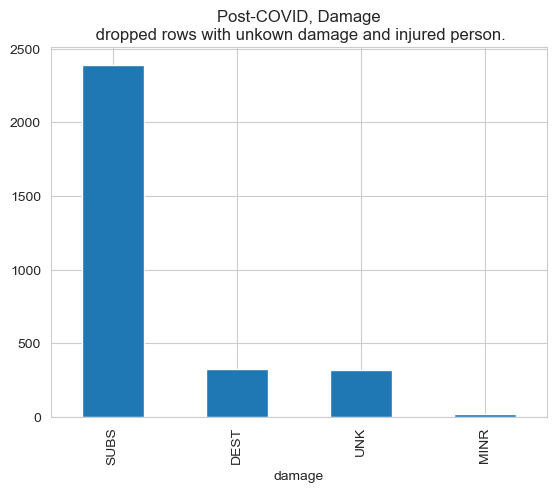

In [29]:
# First plot
df_train['damage'].value_counts().plot(kind='bar')
plt.title('Train, precovid, Damage')
plt.show()  

# Second plot
df_post_covid['damage'].value_counts().plot(kind='bar')
plt.title('Post-COVID, Damage')
plt.show()

# Third plot
condition = (df_post_covid['damage'] == 'UNK') & (df_post_covid['acft_injured_person_count'].isna())
df_post_covid = df_post_covid.loc[~condition]
df_post_covid['damage'].value_counts().plot(kind='bar')
plt.title('Post-COVID, Damage\n dropped rows with unkown damage and injured person.')
plt.show()


In [136]:
features = [#'latitude', 'longitude',    need to change to numeric value first
       'apt_dist', 'gust_kts', 'altimeter',
       'aircraft_count', 'num_eng', 'days_since_insp', 'light_cond_DAYL', 'light_cond_DUSK',
       'light_cond_NDRK', 'light_cond_NITE', 'light_cond_other/unknown',
       'BroadPhaseofFlight_Air', 'BroadPhaseofFlight_Ground',
       'BroadPhaseofFlight_Landing', 'BroadPhaseofFlight_Takeoff',
       'BroadPhaseofFlight_other/unknown', 'eng_type_REC', 'eng_type_TF',
       'eng_type_TP', 'eng_type_TS', 'eng_type_other/unknown', 'far_part_091',
       'far_part_121', 'far_part_135', 'far_part_137', 'far_part_PUBU',
       'far_part_other/unknown', 'acft_make_beech', 'acft_make_bell',
       'acft_make_boeing', 'acft_make_cessna', 'acft_make_mooney',
       'acft_make_other/unknown', 'acft_make_piper',
       'acft_make_robinson helicopter', 'acft_category_AIR',
       'acft_category_HELI', 'acft_category_other/unknown', 'homebuilt_N',
       'homebuilt_Y', 'homebuilt_other/unknown', 'fixed_retractable_FIXD',
       'fixed_retractable_RETR', 'fixed_retractable_other/unknown',
       'second_pilot_N', 'second_pilot_Y', 'second_pilot_other/unknown']

categorical_features = ['aircraft_count',
                     'light_cond_DAYL','light_cond_DUSK','light_cond_NDRK','light_cond_NITE','light_cond_other/unknown',
                     'BroadPhaseofFlight_Air','BroadPhaseofFlight_Ground','BroadPhaseofFlight_Landing','BroadPhaseofFlight_Takeoff','BroadPhaseofFlight_other/unknown',
                     'eng_type_REC','eng_type_TF','eng_type_TP','eng_type_TS','eng_type_other/unknown',
                     'far_part_091','far_part_121','far_part_135','far_part_137','far_part_PUBU','far_part_other/unknown',
                     'acft_make_beech','acft_make_bell','acft_make_boeing','acft_make_cessna','acft_make_mooney','acft_make_other/unknown','acft_make_piper',
                     'acft_make_robinson helicopter','acft_category_AIR','acft_category_HELI','acft_category_other/unknown',
                     'homebuilt_N','homebuilt_Y','homebuilt_other/unknown',
                     'fixed_retractable_FIXD','fixed_retractable_RETR','fixed_retractable_other/unknown',
                     'second_pilot_N','second_pilot_Y','second_pilot_other/unknown']

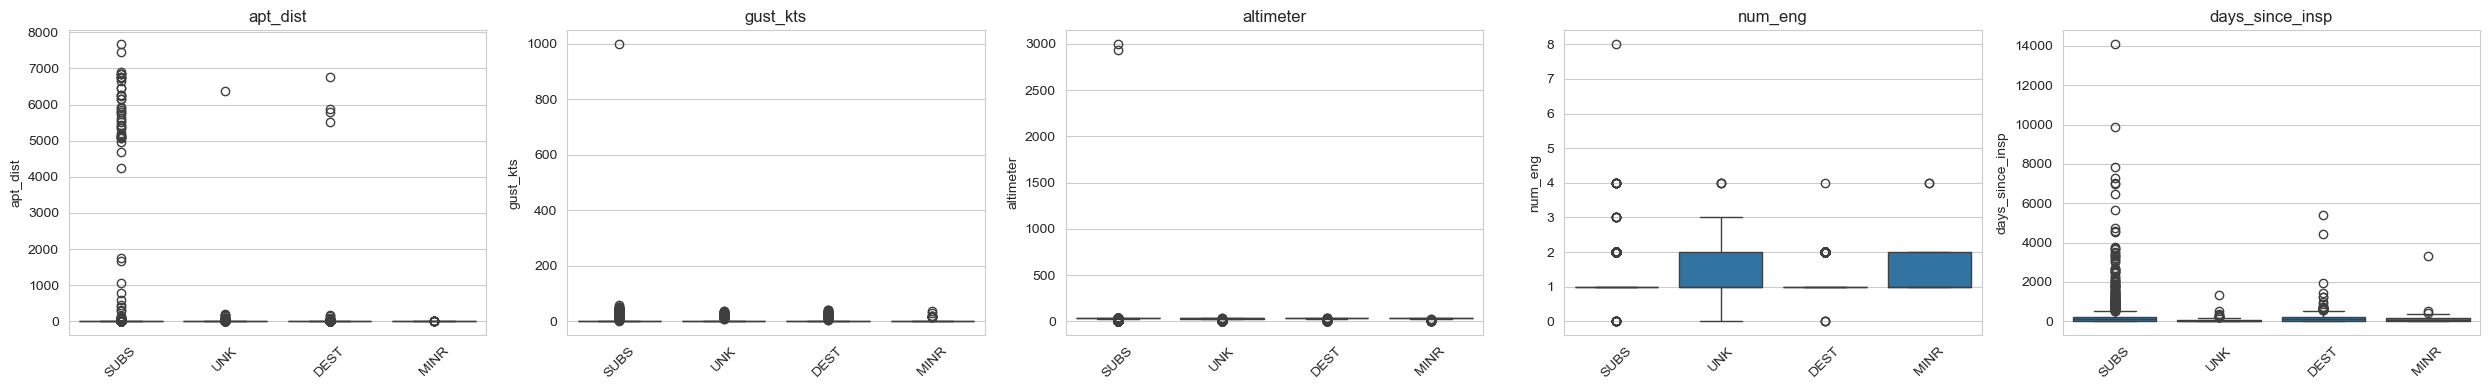

In [65]:
target = 'damage'
# List of numerical features
num_features = ['apt_dist', 'gust_kts', 'altimeter', 'num_eng', 'days_since_insp']
target = 'damage'

# Create a 1-row grid of box plots
fig, axes = plt.subplots(1, len(num_features), figsize=(5 * len(num_features), 4))

for i, feature in enumerate(num_features):
    sns.boxplot(data=df_train, x=target, y=feature, ax=axes[i])
    axes[i].set_title(feature)
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [131]:
## Function for showing histogram in categorical features per damage level.

def show_barplot(categorical_features : list[str], df : pd.DataFrame):
    damage_levels = ['DEST', 'SUBS', 'MINR', 'UNK']
    colors = {'DEST': 'red', 'MINR': 'skyblue', 'SUBS': 'blue', 'UNK': 'cyan'}

    
    
    for feature in categorical_features:
        _, axes = plt.subplots(1, 4, figsize=(5 * 4, 4), squeeze=False)

        for j, dmg in enumerate(damage_levels):
            ax = axes[0, j]
            ax.bar(df[df['damage']==dmg][feature].value_counts(normalize=True).keys(), 
                    df[df['damage']==dmg][feature].value_counts(normalize=True).values, 
                    color=colors[dmg])
            ax.set_title(f"{feature}\n{dmg}", fontsize=10)
            ax.set_ylim(0, 1)
            # ax.tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()
        


# show_barplot([f for f in categorical_features if f.startswith('second')], 
#              df_train)

In [182]:
# Drop Unknown damage
df_train = df_train[df_train[target] != 'UNK']

## Do regression in RandomForestClassifier without selecting features.
## This paragraph is originated from the problem session 10 in Erdos 2025 summer data science boot camp.
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

# Extract features and target from the training DataFrame.
X_train = df_train[features]
y_train = df_train[target]

# As target values are 'MINR', 'SUBS', ..., transform into numerical; 0,1,2,3
# UNKNOWN has been dropped already.

label_order = ['MINR', 'SUBS', 'DEST']
label_map = {label: i for i, label in enumerate(label_order)}

y_train_encoded = y_train.map(label_map)

# Define the parameter ranges.
max_depths = range(1, 11)            # 1 to 10 inclusive
n_estimators_options = [100, 300, 500]

# Shape: (number of max_depth options, number of n_estimators options) = (10, 2)
f1_arr = np.zeros((len(max_depths), len(n_estimators_options)))

# Set up 5-fold cross-validation.
kf = KFold(n_splits=5, shuffle=True, random_state=216)

# Loop over all combinations of max_depth and n_estimators.
for i, max_depth in enumerate(max_depths):
    for j, n_estimators in enumerate(n_estimators_options):
        fold_f1 = []  # To store Accuracy for each fold.
        
        # Perform cross-validation.
        for train_index, test_index in kf.split(X_train):
            # If X is a DataFrame, you can index directly.
            X_tt, X_ho = X_train.iloc[train_index], X_train.iloc[test_index]
            y_tt, y_ho = y_train_encoded.iloc[train_index], y_train_encoded.iloc[test_index]
            


            # Instantiate and train the regressor.
            model = RandomForestClassifier(max_depth=max_depth, 
                                          n_estimators=n_estimators, 
                                          random_state=216)
            model.fit(X_tt, y_tt)
            
            # Predict and compute accuracies for this fold.
            y_pred = model.predict(X_ho)
            f1 = f1_score(y_ho, y_pred, average='weighted')
            fold_f1.append(f1)
        # Store the average accuracy for the current parameter combination.
        f1_arr[i, j] = np.mean(fold_f1)
        

print("Average cross-validation Accuracies for each combination:")
print(f1_arr)

# To get the best parameters:
best_idx = np.unravel_index(np.argmax(f1_arr), f1_arr.shape)
best_max_depth = list(max_depths)[best_idx[0]]
best_n_estimators = n_estimators_options[best_idx[1]]
print(f"Best parameters: max_depth={best_max_depth}, n_estimators={best_n_estimators}")

Average cross-validation Accuracies for each combination:
[[0.86302142 0.86302142 0.86302142]
 [0.86302142 0.86302142 0.86302142]
 [0.86302142 0.86302142 0.86302142]
 [0.86302142 0.86302142 0.86302142]
 [0.86302142 0.86302142 0.86302142]
 [0.86302142 0.86302142 0.86302142]
 [0.86302142 0.86302142 0.86302142]
 [0.8629074  0.86316966 0.86316966]
 [0.86313165 0.86324191 0.86324191]
 [0.86323617 0.86308832 0.86312716]]
Best parameters: max_depth=9, n_estimators=300


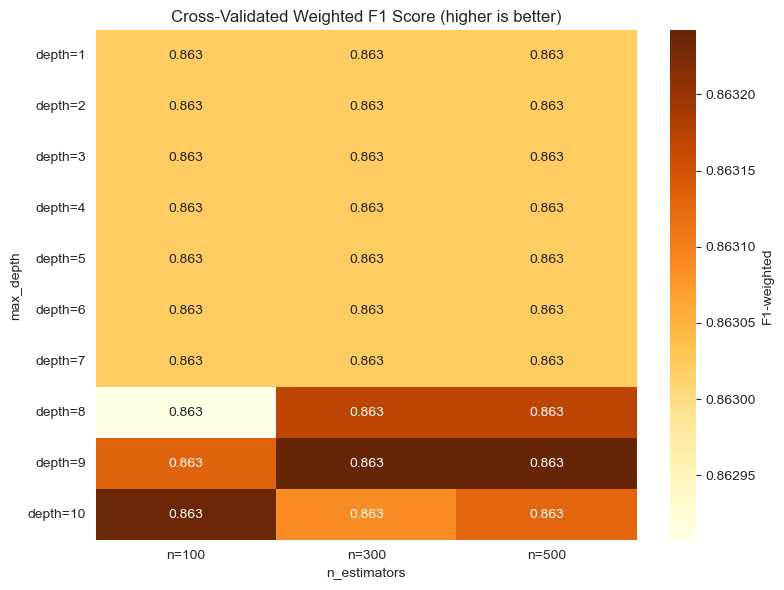

In [183]:
# Make a DataFrame for seaborn
f1_df = pd.DataFrame(
    f1_arr,
    index=[f"depth={d}" for d in max_depths],
    columns=[f"n={n}" for n in n_estimators_options]
)

plt.figure(figsize=(8, 6))
sns.heatmap(f1_df, annot=True, fmt=".3f", cmap="YlOrBr", cbar_kws={'label': 'F1-weighted'})
plt.title("Cross-Validated Weighted F1 Score (higher is better)")
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.tight_layout()
plt.show()

### Functions for random forests

In [166]:
def print_sorted_feature_importances(feat_imps):
    '''
    Takes a dictionary with items 
        feature_name: feature_importance
    and prints the feature name/importance pairs in decreasing order

    Solution taken from https://stackoverflow.com/questions/11228812/print-a-dict-sorted-by-values
    '''
    sorted_feat_imps = sorted( ((imp,feat) for feat,imp in feat_imps.items()), reverse=True)
    for imp,feat in sorted_feat_imps:
        print(f'{feat} importance: {imp}')

In [172]:
def rf_important_features(X,y,features,model=RandomForestClassifier,alpha=0.01,n_estimators=500,max_depth=10):
    '''
    Fit the model on X,y and return a list of features with importance above alpha
    Inputs:
        X: feature data (pd.DataFrame)
        y: target data (pd.Series)
        model: RandomForestRegressor or RandomForestClassifier
        alpha: importance threshold (float)
        n_estimators: number of estimators in RandomForest
        max_dept: max depth of tree in RandomForest
    '''
    rf = model(n_estimators=n_estimators, max_depth=max_depth)
    rf.fit(X, y)

    feat_importances = {}

    for i, feature in enumerate(features):
        feat_importances[feature] = rf.feature_importances_[i]

    important_feats = [feature for feature in feat_importances.keys() if feat_importances[feature] > alpha]

    return important_feats, feat_importances

In [184]:
# Get the important features
important_feats, feat_importances = rf_important_features(X_train,y_train_encoded,features,model=RandomForestClassifier,alpha=0.01,
                                           n_estimators=300, max_depth=9)
# X_small = X_train[important_features]

In [185]:
print_sorted_feature_importances(feat_importances)

days_since_insp importance: 0.11256832856622083
apt_dist importance: 0.10753915831466318
altimeter importance: 0.0925752578752676
BroadPhaseofFlight_Air importance: 0.07431488372465983
aircraft_count importance: 0.06265849061016429
BroadPhaseofFlight_Landing importance: 0.0594314830223234
num_eng importance: 0.03684626238443618
gust_kts importance: 0.033972069855228125
light_cond_NDRK importance: 0.03272628331827679
fixed_retractable_RETR importance: 0.030188559911464404
fixed_retractable_FIXD importance: 0.029816160622063534
light_cond_DAYL importance: 0.026696064791278538
light_cond_NITE importance: 0.018126541227134363
BroadPhaseofFlight_Ground importance: 0.017853295844258286
eng_type_REC importance: 0.017042255462894465
acft_make_other/unknown importance: 0.01697925766247106
BroadPhaseofFlight_Takeoff importance: 0.016054769892798082
second_pilot_N importance: 0.013821033512757475
second_pilot_Y importance: 0.01357088000726561
acft_make_cessna importance: 0.013554597593030664
eng_

In [186]:
X_small = X_train[important_feats]

In [198]:
from sklearn.model_selection import GridSearchCV

grid_cv_small = GridSearchCV(RandomForestClassifier(), 
                          param_grid = {'max_depth':range(1, 11),
                                        'n_estimators':[100,300,500,700,900]}, # and n_estimators here
                          scoring = 'f1_weighted', 
                          cv = 5) # put the number of cv splits here


grid_cv_small.fit(X_small,y_train_encoded)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(1, 11),
                         'n_estimators': [100, 300, 500, 700, 900]},
             scoring='f1_weighted')

In [199]:
feature_importance_df = pd.DataFrame({
    'Feature': important_feats,  
    'Importance': grid_cv_small.best_estimator_.feature_importances_
})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Reset index for better readability
feature_importance_df.reset_index(drop=True, inplace=True)

# Display the DataFrame
print(feature_importance_df)

                       Feature  Importance
0              days_since_insp    0.162042
1                    altimeter    0.136298
2                     apt_dist    0.114810
3       BroadPhaseofFlight_Air    0.059211
4               aircraft_count    0.057799
5                     gust_kts    0.049232
6   BroadPhaseofFlight_Landing    0.045869
7                      num_eng    0.039751
8              light_cond_NDRK    0.027820
9       fixed_retractable_RETR    0.026935
10      fixed_retractable_FIXD    0.026189
11             light_cond_DAYL    0.025185
12     acft_make_other/unknown    0.024528
13                eng_type_REC    0.022885
14            acft_make_cessna    0.020750
15              second_pilot_Y    0.019854
16              second_pilot_N    0.019480
17                far_part_091    0.018842
18                 eng_type_TP    0.018738
19             light_cond_NITE    0.018468
20             acft_make_piper    0.018072
21   BroadPhaseofFlight_Ground    0.016987
22  BroadPh

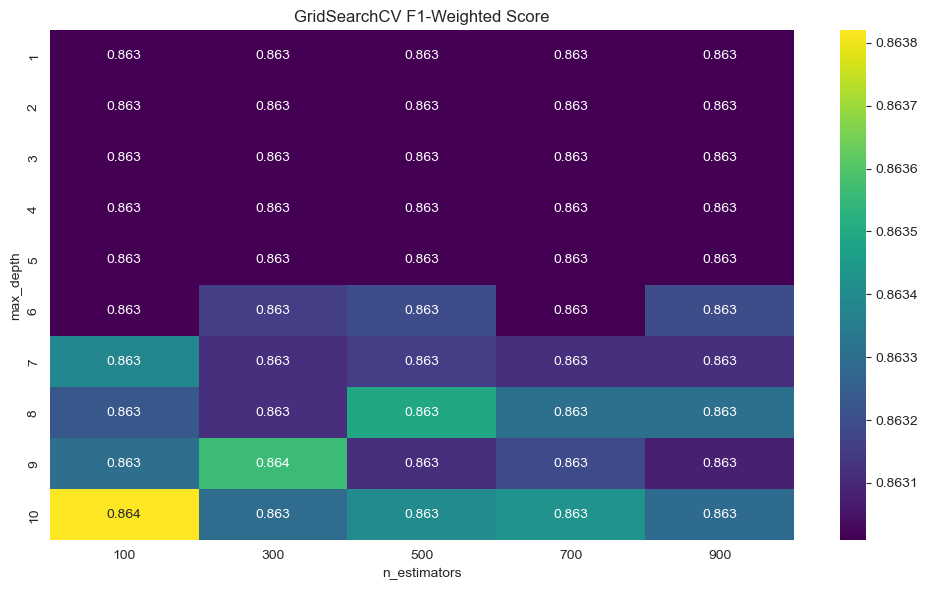

Best Parameters: {'max_depth': 10, 'n_estimators': 100}
Best Weighted F1 Score: 0.8638196598297677


In [200]:
# Get results into a DataFrame
results = pd.DataFrame(grid_cv_small.cv_results_)

# Extract relevant columns
scores_matrix = results.pivot(index='param_max_depth', 
                               columns='param_n_estimators', 
                               values='mean_test_score')

plt.figure(figsize=(10, 6))
sns.heatmap(scores_matrix, annot=True, fmt=".3f", cmap='viridis')
plt.title("GridSearchCV F1-Weighted Score")
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.tight_layout()
plt.show()
print("Best Parameters:", grid_cv_small.best_params_)
print("Best Weighted F1 Score:", grid_cv_small.best_score_)

In [191]:
from sklearn.model_selection import GridSearchCV

grid_cv = GridSearchCV(RandomForestClassifier(), 
                          param_grid = {'max_depth':range(1, 11),
                                        'n_estimators':[100,300,500,700, 900]}, # and n_estimators here
                          scoring = 'f1_weighted', 
                          cv = 5) # put the number of cv splits here


grid_cv.fit(X_train,y_train_encoded)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(1, 11),
                         'n_estimators': [100, 300, 500, 700, 900]},
             scoring='f1_weighted')

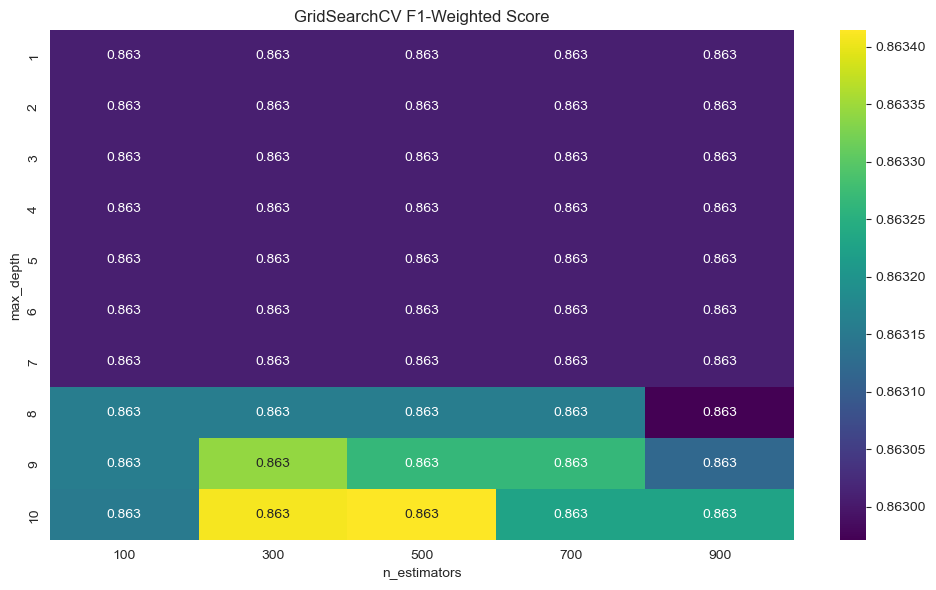

Best Parameters: {'max_depth': 10, 'n_estimators': 500}
Best Weighted F1 Score: 0.8634143829669716


In [197]:
# Get results into a DataFrame
results = pd.DataFrame(grid_cv.cv_results_)

# Extract relevant columns
scores_matrix = results.pivot(index='param_max_depth', 
                               columns='param_n_estimators', 
                               values='mean_test_score')

plt.figure(figsize=(10, 6))
sns.heatmap(scores_matrix, annot=True, fmt=".3f", cmap='viridis')
plt.title("GridSearchCV F1-Weighted Score")
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.tight_layout()
plt.show()
print("Best Parameters:", grid_cv.best_params_)
print("Best Weighted F1 Score:", grid_cv.best_score_)

In [193]:
feature_importance_df = pd.DataFrame({
    'Feature': features,  
    'Importance': grid_cv.best_estimator_.feature_importances_
})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Reset index for better readability
feature_importance_df.reset_index(drop=True, inplace=True)

# Display the DataFrame
print(feature_importance_df)

                             Feature  Importance
0                    days_since_insp    0.125537
1                          altimeter    0.105332
2                           apt_dist    0.104810
3             BroadPhaseofFlight_Air    0.065702
4                     aircraft_count    0.057517
5         BroadPhaseofFlight_Landing    0.051357
6                           gust_kts    0.037543
7                            num_eng    0.035381
8             fixed_retractable_RETR    0.027825
9                    light_cond_NDRK    0.027799
10            fixed_retractable_FIXD    0.027231
11                   light_cond_DAYL    0.024956
12           acft_make_other/unknown    0.017774
13                   light_cond_NITE    0.017636
14                      eng_type_REC    0.017556
15                    second_pilot_N    0.016577
16         BroadPhaseofFlight_Ground    0.015913
17                    second_pilot_Y    0.015181
18                  acft_make_cessna    0.014544
19        BroadPhase

## Notes

Does it make sense to do some batched feature reduction? E.g. for each of the following categories, the variables seem to be largely overlapping
- Location relative to landing: `BroadPhaseofFlight`, `altimiter`, `apt_dst`
- Aircraft type: `num_eng`, `acft_make`, `acft_category`, `acft_total_person_count`, `far_part`

`gust_kts` seems to be important but there's potentially a large amount of corrupted data in there. Should we keep it in?

How much do we have to worry about outliers if we're using a tree-based ensemble model?

Can try putting the categorical variables into XGBoost without one-hot encoding

I tried iteratively refining the list of important features and it seems like little changes on the second iteration

RandomForestRegressor hyperparameters
- Best max_depth = 7, similarly well for 6-9
- Best n_estimators = 200: the difference is marginal for anything above 50, and miniscule for anything above 200 (the difference seems to change trial-by-trial. Read: not statistically significant)

XGB does a bit better. Still not great.

XGB gets ~0.5 macro F1 on `damage` with 4 categrories, that goes down to ~0.4 if we drop the rows with unknown damage. Pretty bad!

In [ ]:
## Approximate number of variables for each feature importance threshold
## This is old code that will no longer run, but the output would be very similar 

# alpha = np.arange(15)/100

# for a in alpha:
#    important_dummies = {item for item in feat_imps.items() if item[1] > a}
#    print(f'Importance threshold {a} -- {len(important_dummies)} variables')

Importance threshold 0.0 -- 47 variables
Importance threshold 0.01 -- 25 variables
Importance threshold 0.02 -- 8 variables
Importance threshold 0.03 -- 7 variables
Importance threshold 0.04 -- 6 variables
Importance threshold 0.05 -- 4 variables
Importance threshold 0.06 -- 4 variables
Importance threshold 0.07 -- 4 variables
Importance threshold 0.08 -- 4 variables
Importance threshold 0.09 -- 4 variables
Importance threshold 0.1 -- 4 variables
Importance threshold 0.11 -- 4 variables
Importance threshold 0.12 -- 3 variables
Importance threshold 0.13 -- 2 variables
Importance threshold 0.14 -- 2 variables


Grid Search Results DataFrame:
   param_max_depth  param_n_estimators  mean_test_score
0                2                 100         0.112324
1                2                 200         0.113401
2                2                 500         0.113690
3                4                 100         0.145664
4                4                 200         0.145004
------------------------------
Pivoted Scores for Heatmap:
param_n_estimators       100       200       500
param_max_depth                                 
2                   0.112324  0.113401  0.113690
4                   0.145664  0.145004  0.145550
6                   0.159535  0.160540  0.160041
8                   0.160781  0.161228  0.161549
10                  0.153751  0.154755  0.154405
------------------------------


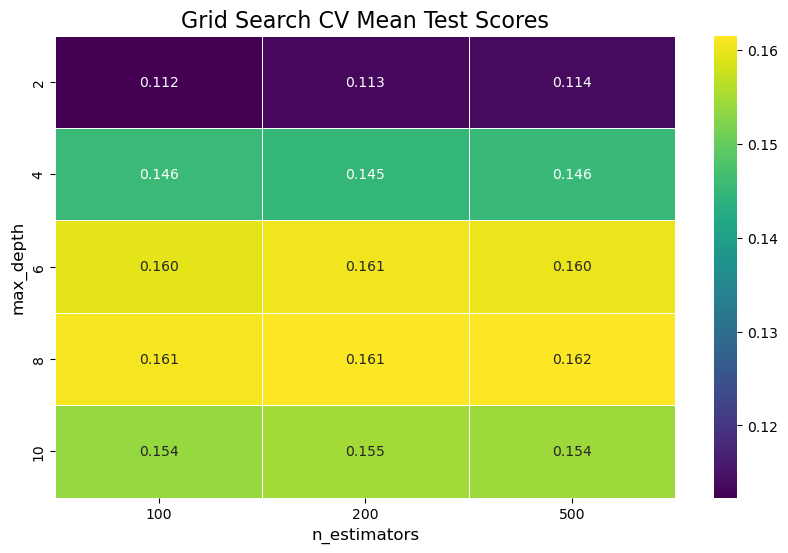

In [ ]:
## Heatmap of a grid search for parameters of a random forest to predict serious/fatal injury proportion
## Looks like increasing n_estimators doesn't accomplish much and it slows down the training/predicting
## Don't re-run, the variables have changed and the plot will look different

# results = pd.DataFrame(grid.cv_results_)

# # You can display the first few rows to see the structure
# print("Grid Search Results DataFrame:")
# print(results[['param_max_depth', 'param_n_estimators', 'mean_test_score']].head())
# print("-" * 30)

# # 2. Pivot the data to create a matrix with max_depth as rows and n_estimators as columns
# scores = results.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')

# print("Pivoted Scores for Heatmap:")
# print(scores)
# print("-" * 30)


# # 3. Create the heatmap using seaborn
# plt.figure(figsize=(10, 6))
# sns.heatmap(
#     scores,
#     annot=True,      # Write the score in each cell
#     fmt=".3f",       # Format the annotations to 3 decimal places
#     linewidths=.5,   # Add lines between cells
#     cmap='viridis'   # Use a visually appealing color map
# )
# plt.title('Grid Search CV Mean Test Scores', fontsize=16)
# plt.xlabel('n_estimators', fontsize=12)
# plt.ylabel('max_depth', fontsize=12)
# plt.show()

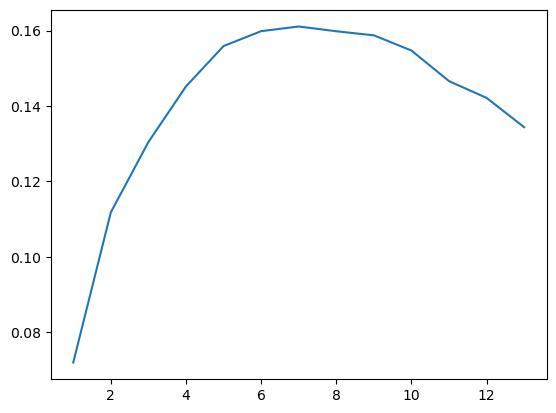

In [ ]:
## Plot of performance for n_estimators = 100, max_depth = 1,2,3,...,13
## Does best for max_depth = 6-9
## Don't re-run, the variables have changed and the plot will look different

# results = pd.DataFrame(grid.cv_results_)
# plt.plot(results['param_max_depth'], results['mean_test_score'])
# plt.show()